In [1]:
#DATA HANDLING 
import pandas as pd # to work wid dataframes..
import dask.dataframe as dd #for handling datasets larger than ram.(mines a shitty system)
import numpy as np #for numerical ops

In [2]:
#MACHINE LEARNING MODELS
import lightgbm as lgb
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier #model tat uses multiple decision trees

In [3]:
#MODEL BUILDING & EVALUATION
from sklearn.model_selection import train_test_split , RandomizedSearchCV #to split data and automatically tune models
from sklearn.metrics import classification_report, confusion_matrix, roc_curve , auc #using this shi to measure the model performance

In [4]:
#FOR PLOTTING
import matplotlib.pyplot as plt
import seaborn as sns
import time

In [5]:
#LOADING THE FULL DATASET AND CLEANING
print("Loading Full Dataset with DASK")
dask_df = dd.read_csv('./data/*.csv',
    encoding='latin1',          #solves potential text encoding errors in the files.
    on_bad_lines='warn',        #wont crash if it finds a malformed line...it will warn me and skip it.
    assume_missing=True,        #helps Dask handle columns with missing values more gracefully.
    dtype={'Flow ID': 'object', #manually sets the data type for known problematic columns to prevent errors.
           'Source IP': 'object',
           'Destination IP': 'object',
           'Timestamp': 'object'}
                     )

Loading Full Dataset with DASK


In [6]:
#REMOVING THE LEADING OR TRAILING SPACES FROM COLUMNS
dask_df.columns = dask_df.columns.str.strip()

In [7]:
#REMOVING ANY IDENTICAL ROWS
dask_df =dask_df.drop_duplicates()

In [9]:
#REPLACING INFINTE VALUES WITH NaN 
dask_df = dask_df.replace([np.inf, -np.inf],np.nan)

In [10]:
#REMOVING ROWS THAT STILL HAS MISSING VALUES
dask_df = dask_df.dropna()

In [11]:
#RETURNING THE FINAL RESULT AS combined_df
combined_df = dask_df.compute()
print(f"Full, cleaned dataset loaded. Shape: {combined_df.shape}")

S:\ML_NIDS_Project\env\Lib\site-packages\dask\dataframe\io\csv.py:77: DtypeWarning: Columns (1,3,6,84) have mixed types. Specify dtype option on import or set low_memory=False.
  df = reader(bio, **kwargs)


Full, cleaned dataset loaded. Shape: (2827677, 85)


In [12]:
#PREPARING DATA FOR MODELING

print("Preparing data for Modelin..")
#Create a new column 'is_attack'. We simplify the problem from 15 attack types to a binary "is it an attack or not?"
#If the 'Label' is 'BENIGN', 'is_attack' is 0. For anything else, it's 1.
combined_df['is_attack'] = combined_df['Label'].apply(lambda x: 0 if x == 'BENIGN' else 1)

Preparing data for Modelin..


In [13]:
#'y' is our target variable—the answer we want the model to predict.
y = combined_df['is_attack']

In [14]:
# 'X' contains our features. We drop the columns we can't use:
# 'Label' and 'is_attack': These are the answers, so we can't use them as clues.
#'Flow ID', IP addresses, 'Timestamp': These are identifiers, not general patterns. Using them would cause the model to just memorize specific connections instead of learning what an attack *looks like*.
X = combined_df.drop(['Label', 'is_attack', 'Flow ID', 'Source IP', 'Destination IP', 'Timestamp'], axis=1)

In [15]:
# We split the data into two parts: a training set (80%) and a testing set (20%).
# The model ONLY learns from the training set. The test set is kept separate to see how well the model performs on new, unseen data.
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2,     # Allocate 20% of the data for testing.
    random_state=42,   # Ensures the split is identical every time you run the code, for reproducible results.
    stratify=y         # Crucial for imbalanced data. Ensures both the training and test sets have the same percentage of attacks.
)

In [16]:
print(f"Training data shape: {X_train.shape}")
print(f"Testing data shape: {X_test.shape}")

Training data shape: (2262141, 80)
Testing data shape: (565536, 80)


In [17]:
#TRAINING AND COMPARING BASELINE MODELS....


#created a dictionary to hold the models i want to test
models = {
    "LightGBM" : lgb.LGBMClassifier(random_state = 42),
    "XGBoost" : xgb.XGBClassifier(random_state = 42 , use_label_encoder = False, eval_metric = 'logloss'),
    "Random Forest (sample)" : RandomForestClassifier(n_jobs=-1, random_state=42)
}

In [18]:
# We create an even smaller sample of the training data just for the Random Forest comparison.
# This is because RF can be much slower and more memory-intensive than LightGBM or XGBoost.
_, X_rf_sample, _, y_rf_sample = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)

In [19]:
# This loop iterates through each model in our dictionary.
for name, model in models.items():
    start_time = time.time()
    print(f"Training {name}...")
    
    # Use the small sample for Random Forest, and the full training set for the others.
    if "Random Forest" in name:
        model.fit(X_rf_sample, y_rf_sample) # The 'fit' command is where the model learns from the data.
    else:
        model.fit(X_train, y_train)
    
    # After training, we use the model to make predictions on the unseen test data.
    y_pred = model.predict(X_test)
    elapsed_time = time.time() - start_time
    print(f"Training and prediction for {name} took {elapsed_time:.2f} seconds.")
    print(f"--- Results for {name} ---")
    
    # This report shows key metrics like precision, recall, and F1-score for both classes.
    print(classification_report(y_test, y_pred, target_names=['BENIGN (0)', 'ATTACK (1)']))
    print("-" * 50)

Training LightGBM...
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 445244, number of negative: 1816897
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 1.254953 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 14839
[LightGBM] [Info] Number of data points in the train set: 2262141, number of used features: 72
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.196824 -> initscore=-1.406263
[LightGBM] [Info] Start training from score -1.406263
Training and prediction for LightGBM took 114.90 seconds.
--- Results for LightGBM ---
              precision    recall  f1-score   support

  BENIGN (0)       1.00      1.00      1.00    454225
  ATTACK (1)       1.00      1.00      1.00    111311

    accuracy                           1.00    565536
   macro avg       1.00      1

S:\ML_NIDS_Project\env\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:48:39] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Training and prediction for XGBoost took 92.77 seconds.
--- Results for XGBoost ---
              precision    recall  f1-score   support

  BENIGN (0)       1.00      1.00      1.00    454225
  ATTACK (1)       1.00      1.00      1.00    111311

    accuracy                           1.00    565536
   macro avg       1.00      1.00      1.00    565536
weighted avg       1.00      1.00      1.00    565536

--------------------------------------------------
Training Random Forest (sample)...
Training and prediction for Random Forest (sample) took 141.31 seconds.
--- Results for Random Forest (sample) ---
              precision    recall  f1-score   support

  BENIGN (0)       1.00      1.00      1.00    454225
  ATTACK (1)       1.00      1.00      1.00    111311

    accuracy                           1.00    565536
   macro avg       1.00      1.00      1.00    565536
weighted avg       1.00      1.00      1.00    565536

--------------------------------------------------


In [21]:
#HYPERPARAMETER TUNING FOR BEST MODEL......

print("\n Hyperparameter tuning for LightGBM")
#dEFINED a dictionary of hyperparameters and a range of values to test for each.
param_dist = {
    'n_estimators': [100, 200, 300],         # Number of trees to build.
    'learning_rate': [0.01, 0.05, 0.1],     # How quickly the model learns.
    'num_leaves': [31, 50, 100],            # Complexity of each tree.
    'max_depth': [-1, 10, 20],              # Maximum depth of each tree.
    'reg_alpha': [0.1, 0.5],                # Regularization to prevent overfitting.
    'reg_lambda': [0.1, 0.5]               # Another type of regularization.
}


 Hyperparameter tuning for LightGBM


In [22]:
# We use another sample for tuning to make the search process faster.
_, X_tune_sample, _, y_tune_sample = train_test_split(X_train, y_train, test_size=0.4, random_state=42, stratify=y_train)

In [23]:
# We initialize a base LightGBM model.
lgb_tuned = lgb.LGBMClassifier(random_state=42)

In [26]:
# RandomizedSearchCV will intelligently test random combinations of the parameters to find the best mix.
# n_iter=10: It will try 10 different combinations.
# cv=3: It uses 3-fold cross-validation, a robust method to evaluate each combination.
# n_jobs=-1: It uses all available CPU cores to speed up the search.
random_search = RandomizedSearchCV(
    lgb_tuned, param_distributions=param_dist, n_iter=10, 
    cv=3, n_jobs=1, verbose=2, random_state=42
)

In [28]:
print("Starting randomized search for best hyperparameters...")
# This 'fit' command starts the entire search process.
random_search.fit(X_tune_sample, y_tune_sample)

# After the search is complete, we can access the best settings found.
print(f"Best parameters found: {random_search.best_params_}")
# This object is the best model, already trained on the tuning data with the best parameters.
best_lgbm = random_search.best_estimator_

Starting randomized search for best hyperparameters...
Fitting 3 folds for each of 10 candidates, totalling 30 fits
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 118732, number of negative: 484506
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.306274 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 14836
[LightGBM] [Info] Number of data points in the train set: 603238, number of used features: 72
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.196824 -> initscore=-1.406261
[LightGBM] [Info] Start training from score -1.406261
[CV] END learning_rate=0.05, max_depth=-1, n_estimators=300, num_leaves=31, reg_alpha=0.1, reg_lambda=0.1; total time= 1.4min
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive

In [29]:
#FINAL EVALUATION OF THE TUNED MODEL

print("\n Final evaluation of the tuned LightGBM model")
y_pred_final = best_lgbm.predict(X_test)

print("\nFinal Classification Report:")
print(classification_report(y_test, y_pred_final, target_names=['BENIGN (0)', 'ATTACK (1)']))



 Final evaluation of the tuned LightGBM model

Final Classification Report:
              precision    recall  f1-score   support

  BENIGN (0)       1.00      1.00      1.00    454225
  ATTACK (1)       1.00      1.00      1.00    111311

    accuracy                           1.00    565536
   macro avg       1.00      1.00      1.00    565536
weighted avg       1.00      1.00      1.00    565536



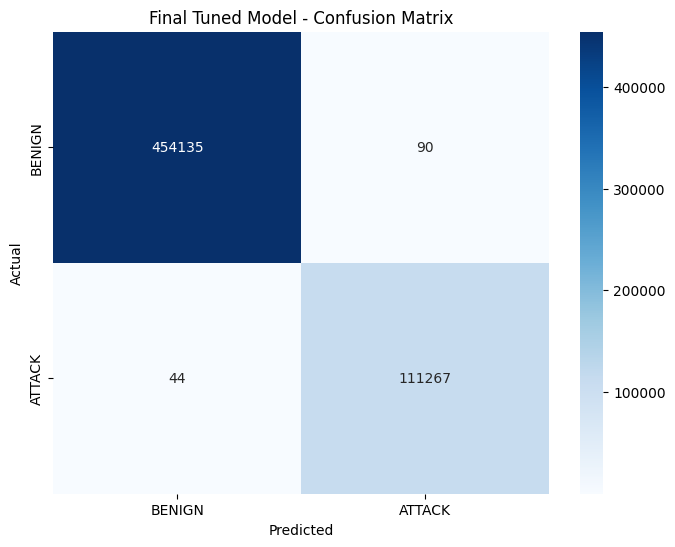

In [30]:
#CONFUSION MATRIX
cm = confusion_matrix(y_test, y_pred_final)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['BENIGN', 'ATTACK'], yticklabels=['BENIGN', 'ATTACK'])
plt.title('Final Tuned Model - Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()


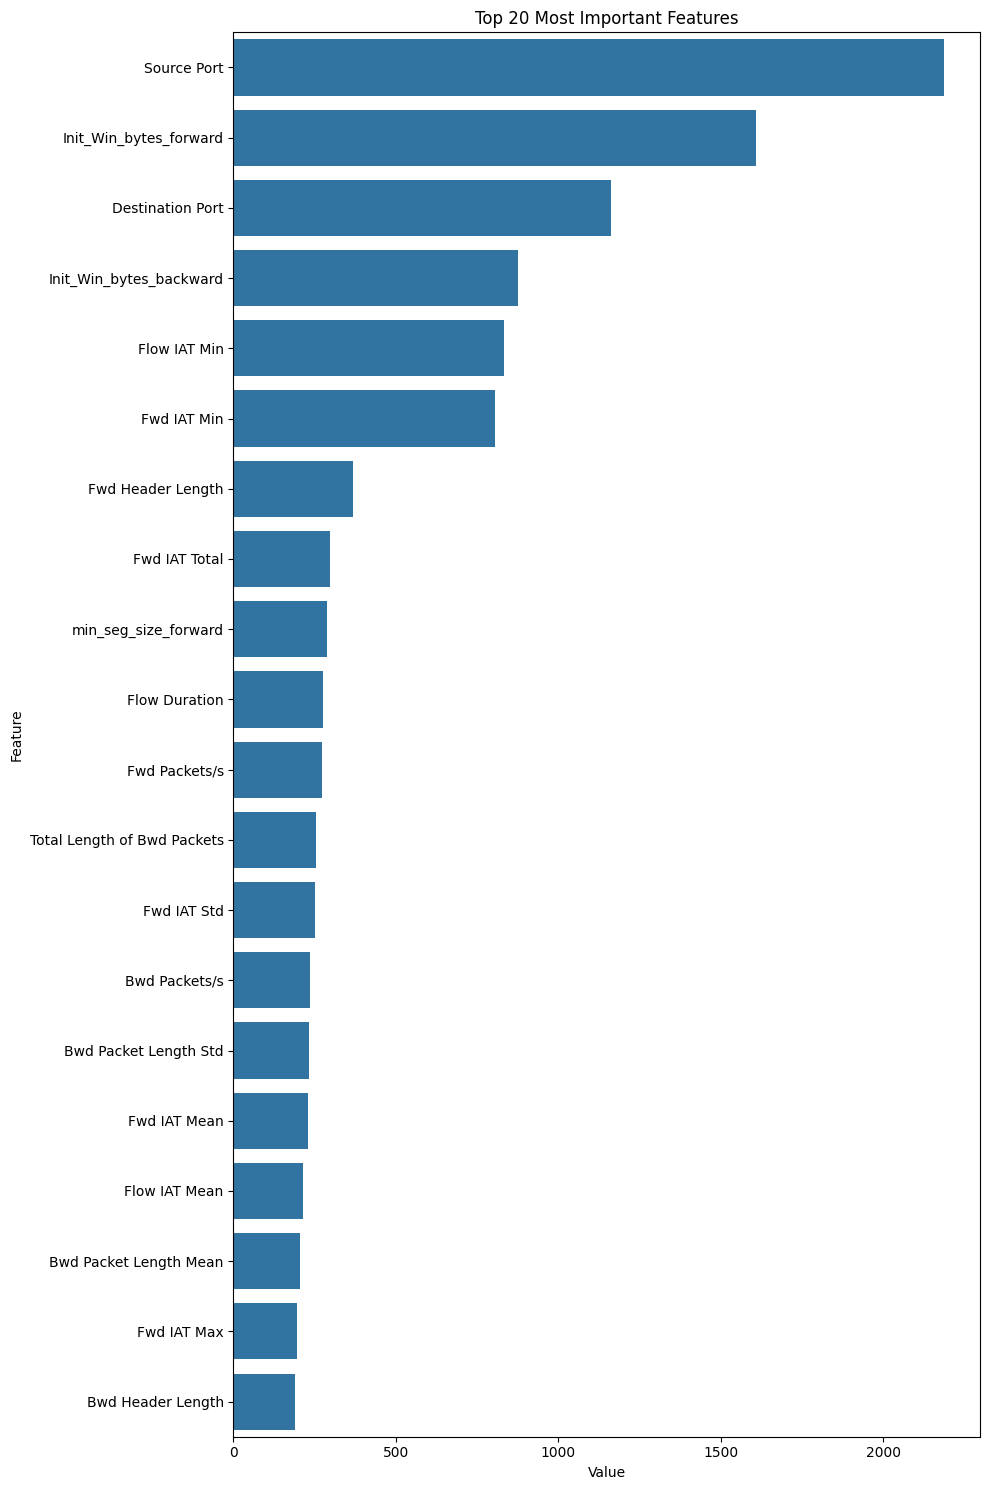

In [31]:
#FEATURE IMPORTANCE
feature_imp = pd.DataFrame(sorted(zip(best_lgbm.feature_importances_, X.columns)), columns=['Value','Feature'])
plt.figure(figsize=(10, 15))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False).head(20))
plt.title('Top 20 Most Important Features')
plt.tight_layout()
plt.show()

--- Initializing SHAP Explainer ---
--- Calculating SHAP Explanation object for a sample ---
The shape of the Explanation object is: (100, 80)

--- SHAP Force Plot for a Single Prediction ---


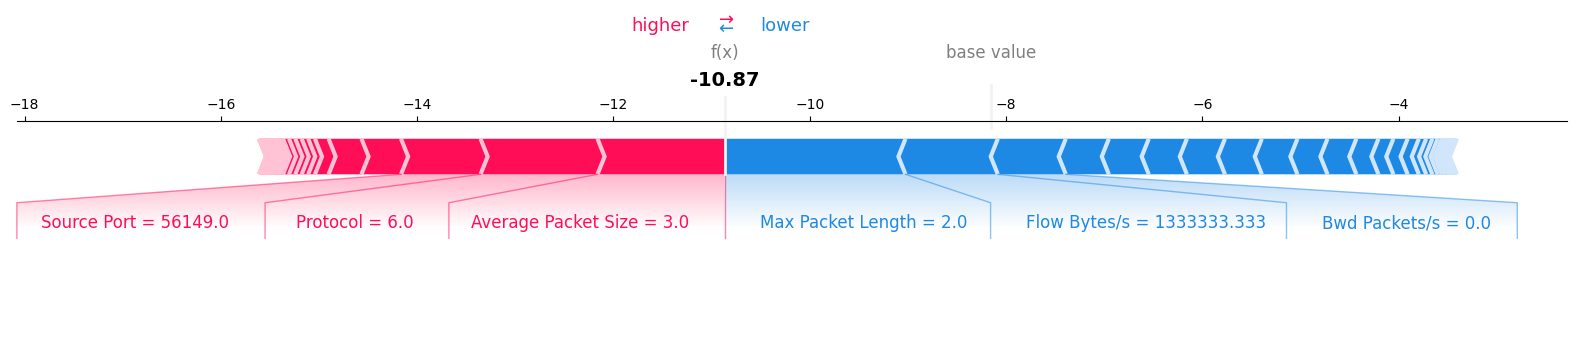


--- Generating a Sample SOC-Style Alert ---

      *** SOC ALERT ***
PREDICTION: BENIGN (Confidence: 0.00%)

TOP 3 CONTRIBUTING FACTORS:
  - Feature 'Init_Win_bytes_forward' with value '63740.0' DECREASED the risk score.
  - Feature 'Source Port' with value '1589.0' DECREASED the risk score.
  - Feature 'Protocol' with value '6.0' INCREASED the risk score.


In [45]:
import shap
import pandas as pd

# --- 1. Initialize the SHAP Explainer (Same) ---
print("--- Initializing SHAP Explainer ---")
explainer = shap.TreeExplainer(best_lgbm)

# --- 2. Calculate a SHAP Explanation object (Same) ---
print("--- Calculating SHAP Explanation object for a sample ---")
X_test_sample = X_test.head(100)
shap_explanation = explainer(X_test_sample)

# --- Optional: See the actual dimensions ---
print(f"The shape of the Explanation object is: {shap_explanation.shape}")


# --- 3. Visualize a Single Prediction (SIMPLIFIED & CORRECTED) ---
print("\n--- SHAP Force Plot for a Single Prediction ---")
shap.initjs()

# THE FIX: We simply index the first sample [0]. No complex slicing needed.
shap.force_plot(shap_explanation[0],matplotlib = True)


# --- 4. Create a SOC-Style Alert Function (SIMPLIFIED & CORRECTED) ---
def generate_soc_alert(row_index):
    """
    Generates a human-readable alert for a given prediction.
    """
    row_to_explain = X_test.iloc[[row_index]]
    prediction = best_lgbm.predict(row_to_explain)[0]
    prediction_proba = best_lgbm.predict_proba(row_to_explain)[0][1]
    
    # Generate an Explanation object for just this one row
    exp = explainer(row_to_explain)
    
    # THE FIX: The values and data are directly on the explanation object.
    # We select the first (and only) row of values with .values[0]
    feature_impacts = pd.DataFrame({
        'feature': exp.feature_names,
        'feature_value': exp.data[0],
        'shap_value': exp.values[0]
    })
    
    feature_impacts['abs_shap'] = feature_impacts['shap_value'].abs()
    top_contributors = feature_impacts.sort_values('abs_shap', ascending=False).head(3)

    print("\n" + "="*50)
    print("      *** SOC ALERT ***")
    print("="*50)
    print(f"PREDICTION: {'ATTACK' if prediction == 1 else 'BENIGN'} (Confidence: {prediction_proba:.2%})")
    print("\nTOP 3 CONTRIBUTING FACTORS:")
    for _, row in top_contributors.iterrows():
        direction = "INCREASED" if row['shap_value'] > 0 else "DECREASED"
        print(f"  - Feature '{row['feature']}' with value '{row['feature_value']}' {direction} the risk score.")
    print("="*50)

# --- 5. Generate a Sample Alert (Same) ---
print("\n--- Generating a Sample SOC-Style Alert ---")
attack_indices = y_test[y_pred_final == 1].index
if not attack_indices.empty:
    generate_soc_alert(attack_indices[0])
else:
    print("No attacks were predicted in the test set to generate an alert for.")

In [ ]:
### System Architecture Diagram

This diagram shows the flow of data from network sensors to the final alert for a SOC analyst.

```
+----------------+      +----------------+      +-------------------+      +-----------------+
| Network Sensor |      |                |      |                   |      |                 |
| (e.g., Zeek)   |----->| Kafka (Stream) |----->| Feature Eng.      |----->|  Model Serving  |
|                |      |                |      | (Python/Spark)    |      |   (REST API)    |
+----------------+      +----------------+      +-------------------+      +-------+---------+
                                                                                     |
                                                                                     | (Alert + SHAP)
                                                                                     v
                                                                            +--------+--------+
                                                                            |                 |
                                                                            | SIEM / Dashboard|
                                                                            | (e.g., Splunk)  |
                                                                            +-----------------+
```

In [47]:
#SAVING MY TRAINED MODEL

import joblib

# Save the model object to a file
model_filename = 'lgbm_nids_model.joblib'
joblib.dump(best_lgbm, model_filename)

# Save the columns used for training, we'll need this for the API
model_columns = list(X.columns)
joblib.dump(model_columns, 'model_columns.joblib')

print(f"Model saved to {model_filename}")
print(f"Model columns saved to model_columns.joblib")

Model saved to lgbm_nids_model.joblib
Model columns saved to model_columns.joblib


In [51]:
#CREATE A PREDICTION FUNCTION (API Simulation)

import pandas as pd
import shap
import joblib

def predict_network_flow(data_dict):
    """
    Simulates a REST API endpoint for making a single prediction.
    
    Args:
        data_dict (dict): A dictionary representing a single network flow.
    
    Returns:
        dict: A dictionary with the prediction and explanation.
    """
    #Load the pre-trained model and columns
    model = joblib.load('lgbm_nids_model.joblib')
    model_cols = joblib.load('model_columns.joblib')

    # --- Create DataFrame from input data ---
    # Ensure the column order is the same as the training data
    flow_df = pd.DataFrame([data_dict], columns=model_cols)

    # --- Make Prediction ---
    prediction = model.predict(flow_df)[0]
    confidence = model.predict_proba(flow_df)[0][1] # Probability of being an attack


     # --- Generate Explanation ---
    explainer = shap.TreeExplainer(model)
    exp = explainer(flow_df)

    # Extract values for the positive class (ATTACK)
    shap_values_for_attack = exp.values[:,:,1][0] if len(exp.values.shape) == 3 else exp.values[0]

    feature_impacts = pd.DataFrame({
        'feature': exp.feature_names,
        'shap_value': shap_values_for_attack
    }).sort_values(by='shap_value', ascending=False, key=abs).head(3)


    result = {
        'prediction': 'ATTACK' if prediction == 1 else 'BENIGN',
        'confidence_of_attack': f"{confidence:.2%}",
        'top_contributing_features': feature_impacts.to_dict('records')
    }
    
    return result
    

In [52]:
#TESTING API WITH SAMPLE DATA

import pprint # Used for printing dictionaries nicely

# Grab the first row from our test set and turn it into a dictionary
sample_flow = X_test.iloc[0].to_dict()

print("--- Sending Sample Flow to Prediction API ---")
pprint.pprint(sample_flow)

print("\n--- API Response ---")
prediction_result = predict_network_flow(sample_flow)
pprint.pprint(prediction_result)

# Test with another sample
print("\n--- Testing Another Sample ---")
sample_flow_2 = X_test.iloc[50].to_dict()
prediction_result_2 = predict_network_flow(sample_flow_2)
pprint.pprint(prediction_result_2)

--- Sending Sample Flow to Prediction API ---
{'ACK Flag Count': 0.0,
 'Active Max': 0.0,
 'Active Mean': 0.0,
 'Active Min': 0.0,
 'Active Std': 0.0,
 'Average Packet Size': 3.0,
 'Avg Bwd Segment Size': 0.0,
 'Avg Fwd Segment Size': 2.0,
 'Bwd Avg Bulk Rate': 0.0,
 'Bwd Avg Bytes/Bulk': 0.0,
 'Bwd Avg Packets/Bulk': 0.0,
 'Bwd Header Length': 0.0,
 'Bwd IAT Max': 0.0,
 'Bwd IAT Mean': 0.0,
 'Bwd IAT Min': 0.0,
 'Bwd IAT Std': 0.0,
 'Bwd IAT Total': 0.0,
 'Bwd PSH Flags': 0.0,
 'Bwd Packet Length Max': 0.0,
 'Bwd Packet Length Mean': 0.0,
 'Bwd Packet Length Min': 0.0,
 'Bwd Packet Length Std': 0.0,
 'Bwd Packets/s': 0.0,
 'Bwd URG Flags': 0.0,
 'CWE Flag Count': 0.0,
 'Destination Port': 8088.0,
 'Down/Up Ratio': 0.0,
 'ECE Flag Count': 0.0,
 'FIN Flag Count': 0.0,
 'Flow Bytes/s': 1333333.333,
 'Flow Duration': 3.0,
 'Flow IAT Max': 3.0,
 'Flow IAT Mean': 3.0,
 'Flow IAT Min': 3.0,
 'Flow IAT Std': 0.0,
 'Flow Packets/s': 666666.6667,
 'Fwd Avg Bulk Rate': 0.0,
 'Fwd Avg Bytes/Bulk'